In [39]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as dist

In [40]:
class GR4J(nn.Module):

    def __init__(self, s_init=0, r_init=0):
        super(GR4J, self).__init__()
        self.s_init = s_init
        self.r_init = r_init
        self.x1 = nn.Parameter(dist.uniform.Uniform(100, 1200).sample())
        self.h1 = nn.Linear(4, 16)
        self.o = nn.Linear(16, 1)

    
    def forward(self, prec, etp):
        
        # Number of simulation timesteps
        num_timesteps = len(prec)
        
        # Unpack the model parameters
        x1 = self.x1

        # Production Storage
        p_n = torch.relu(prec - etp)
        e_n = torch.relu(etp - prec)

        # Production store
        num_timesteps = len(prec)
        p_s = torch.zeros(num_timesteps)
        e_s = torch.zeros(num_timesteps)
        perc = torch.zeros(num_timesteps)
        s_store = torch.zeros(num_timesteps + 1)
        s_store[0] = self.s_init * x1

        for t in range(num_timesteps):
            # calculate fraction of netto precipitation that fills
            #  production store (eq. 3)
            p_s[t] = ((x1 * (1 - (s_store[t-1] / x1)**2) * torch.tanh(p_n[t]/x1)) /
                (1 + s_store[t-1] / x1 * torch.tanh(p_n[t] / x1)))

            # from the production store (eq. 4)
            e_s[t] = ((s_store[t-1] * (2 - s_store[t-1]/x1) * torch.tanh(e_n[t]/x1)) 
                / (1 + (1 - s_store[t-1] / x1) * torch.tanh(e_n[t] / x1)))

            s_store[t] = s_store[t - 1] + p_s[t] - e_s[t]





           
        # return all but the artificial 0's step
        return 

In [41]:
data_location = os.path.join('/data')

In [42]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2000

# Holdout period
holdout_start_year = 2000
holdout_end_year = 2005

In [43]:
# Load the data
maulescreek_rain_et = pd.read_csv(
    os.path.join(
        data_location,
        'SILO(-30.5,150.1)',
        'FAO56_Penman_Monteith_1989.csv'
    )
)
maulescreek_streamflow = pd.read_csv(
    os.path.join(
        data_location,
        'water_level',
        'bom_gauge_daily_mean_419051.csv'
    )
)

# fix dates 
maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

In [44]:
# 
merged_data = pd.merge(
    maulescreek_rain_et,
    maulescreek_streamflow,
    left_on='Date',
    right_on='Date'
)

# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['Date']).dt.year >= calib_start_year) & ((merged_data['Date']).dt.year < calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['Date']).dt.year >= holdout_start_year) & ((merged_data['Date']).dt.year < holdout_end_year)].reset_index(drop=True)

In [45]:
# Tune GR4J parameters
prcp_calib = torch.from_numpy(calibration_data.loc[:, 'Rain'].values)
et_calib = torch.from_numpy(calibration_data.loc[:, 'FAO56'].values)
flow_calib = torch.from_numpy(calibration_data.loc[:, 'Value'].values)
date_calib = calibration_data.loc[:, 'Date'].values


In [48]:
model = GR4J()
result = model(prec=prcp_calib, etp=et_calib)

In [32]:
result[0]

tensor([0.0000, 0.0000, 0.0000,  ..., 0.5894, 0.5838, 0.5781],
       grad_fn=<SliceBackward0>)

In [53]:
def nse(targets, predictions):
    return 1-(torch.sum((targets-predictions)**2)/torch.sum((targets-torch.mean(targets))**2))

def nnse(targets, predictions):
    return 1/(2 - nse(targets, predictions))

def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model(prcp, et)[0]

    nse_score = nse(flow, flow_pred)
    nnse_score = nnse(flow, flow_pred)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, flow.numpy(), label='obs')
    ax.plot(dates, flow_pred.detach().numpy(), label='pred')

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

NSE: -0.009
Normalized NSE: 0.498


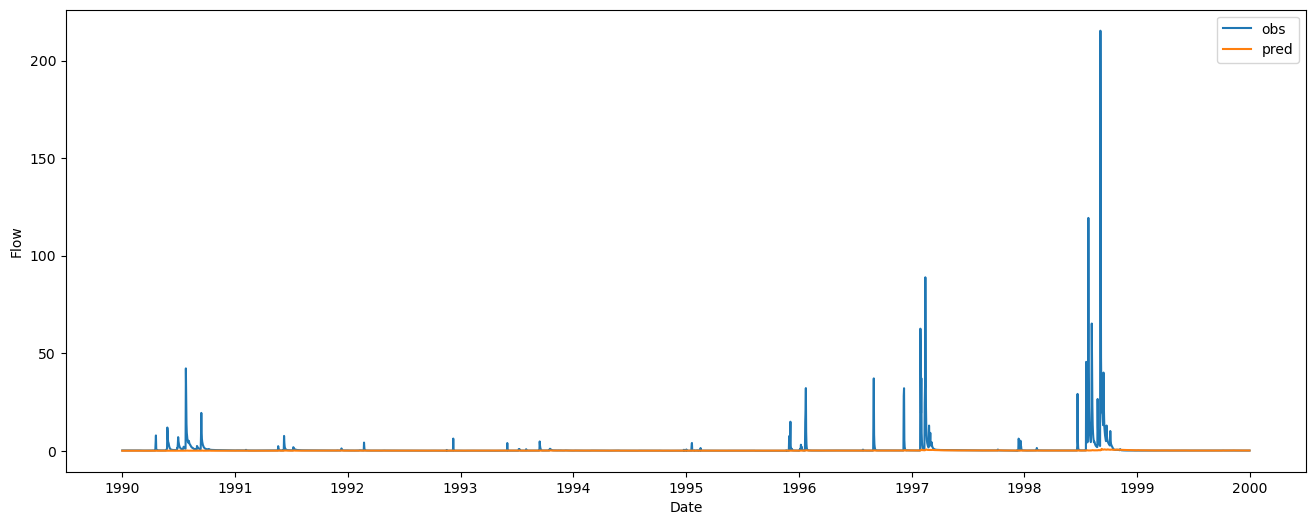

In [54]:
evaluate(model, date_calib,  et_calib, prcp_calib, flow_calib)

NSE: -0.001
Normalized NSE: 0.500


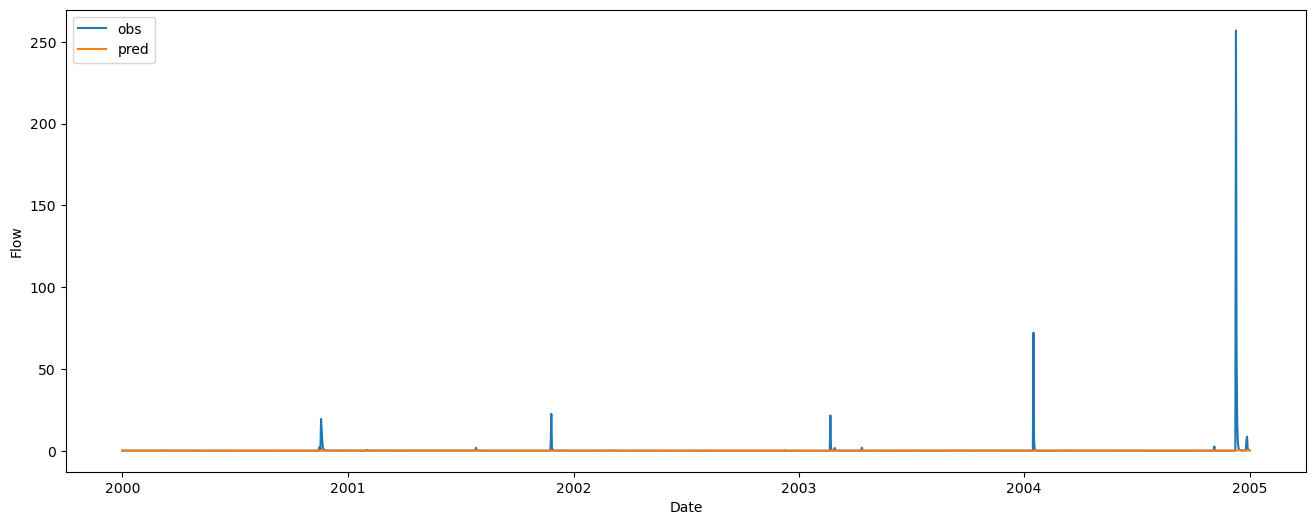

In [55]:
# Evaluate on unseen data
prcp_holdout = torch.from_numpy(holdout_data.loc[:, 'Rain'].values)
et_holdout= torch.from_numpy(holdout_data.loc[:, 'FAO56'].values)
flow_holdout = torch.from_numpy(holdout_data.loc[:, 'Value'].values)
date_holdout = holdout_data.loc[:, 'Date'].values

evaluate(model, date_holdout,  et_holdout, prcp_holdout, flow_holdout)


In [56]:
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(
    prcp_calib,
    et_calib,
    flow_calib
)

train_loader = DataLoader(train_set, batch_size=128)

In [57]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)


In [58]:
for epoch in range(100):

    opt.zero_grad()

    for prcp, et, flow in train_loader:

        pred_flow = model(prcp, et)[0]

        loss = nnse(flow, pred_flow)

        loss.backward()

    opt.step()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor []], which is output 0 of AsStridedBackward0, is at version 257; expected version 256 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).